In [4]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# Run once
#!pip install --no-cache -U pystan==2.19.1.1 prophet

In [7]:
import os
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
import investpy
from datetime import date, datetime
from pathlib import Path
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass, field
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

In [8]:
%matplotlib inline
pd.set_option('display.max_rows', 500)

In [9]:
COUNTRY = "malaysia"                   
DATASET_FOLDER = "test_data"
TARGET_DATASET_FOLDER = f"{DATASET_FOLDER}/{COUNTRY}"
STOCKS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks.csv"
STOCKS_INFO_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_info.csv"
STOCKS_FINANCE_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_finance.csv"
STOCKS_DIVIDENDS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_dividends.csv"
STOCKS_SELECTED = f"{TARGET_DATASET_FOLDER}/stocks_selected.csv"
STOCKS_HISTORICAL_PRICES = f"{TARGET_DATASET_FOLDER}/stocks_historcal_prices.csv"

FROM_DATE = '1/1/2015'
TO_DATE = datetime.strftime(date.today(), '%d/%m/%Y')

In [10]:
def save_csv(df, file_name, index=True):
    df.to_csv(file_name, header=True, index=index)

In [11]:
df_stocks_selected = pd.read_csv(STOCKS_SELECTED)
display(df_stocks_selected.head(30))

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date,PE,Symbol,Yield
0,MBBM,8.170,8.16-8.32,22890000000.0,8.170,6.96-9.01,0.60,11938400.0,95530000000.0,0.52(6.50%),6173324.0,13.53,1.07,8.21%,1.169334e+10,26/08/2021,13.53,MBBM,10.310
1,BSTB,2.000,1.99-2.04,4830000000.0,2.000,1.88-2.27,0.14,811000.0,2680000000.0,0.12(6.16%),577756.0,14.73,0.08,-4.27%,1.341900e+09,16/11/2021,14.73,BSTB,14.250
2,BMYS,7.330,7.35-7.53,878.24M,7.350,7.31-9.9,0.54,3397500.0,5930000000.0,0.50(6.61%),1280013.0,13.57,1.21,-26.26%,8.092991e+08,02/11/2021,13.57,BMYS,8.620
3,BATO,14.000,13.96-14.1,2450000000.0,13.980,9.8-16.2,0.95,178200.0,359310000000.0,0.93(6.60%),316373.0,14.74,0.49,35.92%,2.288578e+09,24/08/2021,14.74,BATO,31.240
4,UOAD,1.590,1.58-1.62,609.5M,1.600,1.46-1.92,0.15,1813800.0,3700000000.0,0.14(8.86%),558834.0,10.75,0.78,-4.22%,2.326466e+09,31/08/2021,10.75,UOAD,8.320
5,TPGC,3.760,3.74-3.85,17400000000.0,3.770,3.64-9.72,1.05,7641600.0,30110000000.0,0.59(15.72%),19801147.0,3.58,0.78,-59.7%,8.006863e+09,17/09/2021,3.58,TPGC,17.435
6,ASTR,1.090,1.08-1.11,4370000000.0,1.090,0.71-1.26,0.12,3623600.0,5680000000.0,0.09(7.87%),5383905.0,9.37,1.32,42.48%,5.214507e+09,16/09/2021,9.37,ASTR,21.245
7,KRIB,3.060,3.04-3.17,6760000000.0,3.070,2.93-8.39,1.17,3109300.0,7810000000.0,0.24(7.64%),5491692.0,2.61,1.42,-62.68%,2.551620e+09,08/11/2021,2.61,KRIB,8.055
8,BERA,1.580,1.57-1.63,2290000000.0,1.590,1.12-1.64,0.12,4542600.0,1840000000.0,0.05(3.17%),1953342.0,13.74,1.35,14.49%,1.161428e+09,16/09/2021,13.74,BERA,12.810
9,DOMN,0.815,0.825-0.87,601.04M,0.825,0.655-1.2,0.09,589800.0,134.67M,0.03(4.29%),84497.0,8.98,0.49,18.12%,1.652402e+08,30/08/2021,8.98,DOMN,10.835


In [12]:
def get_stock_historical_prices(symbol, country):
    try:
        return investpy.get_stock_historical_data(symbol, country, FROM_DATE, TO_DATE)
    except:
        return None
    
def download_historical_prices(df):
    df_history = None
    count = 0
    for _, row in df.iterrows():
        count = count + 1
        print(f"{count}/{len(df)}: {row.Symbol}")
        df_stock = get_stock_historical_prices(row.Symbol, COUNTRY)
        if df_stock is None:
            continue
        df_stock['Symbol'] = row.Symbol
        if df_history is None:
            df_history  = df_stock
        else:
            df_history = df_history.append(df_stock)
        if count % 10 == 0:
            save_csv(df_history, STOCKS_HISTORICAL_PRICES)
            time.sleep(3)
    save_csv(df_history, STOCKS_HISTORICAL_PRICES)

In [13]:
#download_historical_prices(df_stocks_selected)

## Forecast Changes

In [14]:
df_history = pd.read_csv(STOCKS_HISTORICAL_PRICES, parse_dates=['Date'])
display(df_history.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47491 entries, 0 to 47490
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      47491 non-null  datetime64[ns]
 1   Open      47491 non-null  float64       
 2   High      47491 non-null  float64       
 3   Low       47491 non-null  float64       
 4   Close     47491 non-null  float64       
 5   Volume    47491 non-null  int64         
 6   Currency  47491 non-null  object        
 7   Symbol    47491 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 2.9+ MB


None

<AxesSubplot:>

,index,Date,Open,High,Low,Close,Volume,Currency,Symbol
0,0,2015-01-02,9.17,9.17,9.05,9.12,10216400,MYR,MBBM
1,1,2015-01-05,9.14,9.17,8.98,9.00,14354500,MYR,MBBM
2,2,2015-01-06,8.90,9.00,8.64,8.80,20485400,MYR,MBBM
3,3,2015-01-07,8.69,8.70,8.58,8.61,25785100,MYR,MBBM
4,4,2015-01-08,8.64,8.76,8.64,8.70,13590000,MYR,MBBM
5,5,2015-01-09,8.62,8.63,8.49,8.61,22071800,MYR,MBBM
6,6,2015-01-12,8.60,8.62,8.47,8.58,10247700,MYR,MBBM
7,7,2015-01-13,8.58,8.66,8.56,8.62,7419000,MYR,MBBM
8,8,2015-01-14,8.62,8.62,8.38,8.39,24945700,MYR,MBBM
9,9,2015-01-15,8.40,8.62,8.40,8.60,17100900,MYR,MBBM


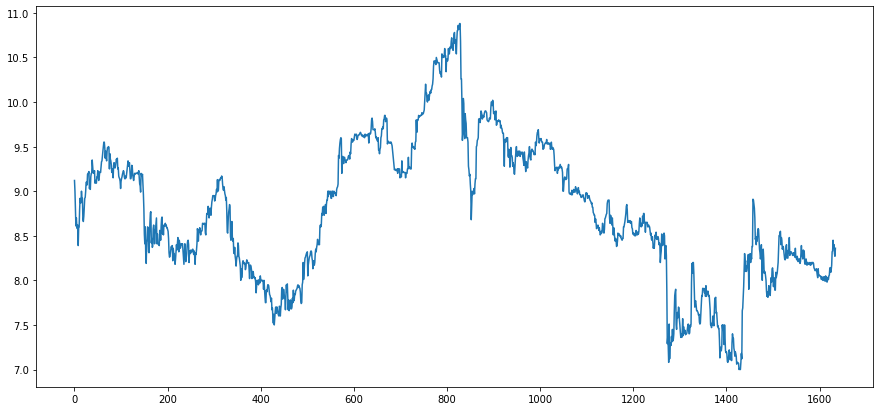

In [15]:
# Try with 1 stock
df_stock = df_history[df_history['Symbol'] == 'MBBM'].copy()
df_stock.reset_index(inplace=True)
df_stock['Close'].plot(figsize = (15,7))

df_stock.head(10)

In [16]:
# Features to test
INTERVAL = 3
PCT_CHANGE_EXPECTED = 0.02

df_analysis = df_stock[['Date', 'Close']]

df_interval_price_mean = df_analysis['Close'].groupby(df_analysis.index // INTERVAL).mean()
df_interval_price_min = df_analysis['Close'].groupby(df_analysis.index // INTERVAL).min()
df_interval_price_max = df_analysis['Close'].groupby(df_analysis.index // INTERVAL).max()

df_interval_date_min = df_analysis['Date'].groupby(df_analysis.index // INTERVAL).min()

#display(df_interval_date_min.head(10))
#display(df_interval_price_mean.head(10))

ds = []
y  = []
for idx, val in df_interval_date_min.items():
    ohlc = df_stock[df_stock['Date'] == val]
    open_price  = float(ohlc['Open'])
    
    price_mean = df_interval_price_mean.iloc[idx]
    price_max = df_interval_price_max.iloc[idx]
    price_min = df_interval_price_min.iloc[idx]
    
    pct_change_mean = (price_mean - open_price) / open_price
    pct_change_min = (price_min - open_price) / open_price
    pct_change_max = (price_max - open_price) / open_price
    
    ds.append(val)
    if pct_change_max >= PCT_CHANGE_EXPECTED:
        y.append(pct_change_max)
    else:
        y.append(pct_change_mean)
        #y.append(pct_change_min)
        
   
df_analysis = pd.DataFrame.from_dict({'ds': ds, 'y': y})
df_analysis.tail(10)

,ds,y
535,2021-07-22,-0.000830
536,2021-07-27,0.000831
537,2021-07-30,-0.007838
538,2021-08-04,-0.001247
539,2021-08-09,0.001667
540,2021-08-13,0.009155
541,2021-08-18,-0.005310
542,2021-08-23,0.025862
543,2021-08-26,0.009204
544,2021-09-01,-0.022353


Initial log joint probability = -31.0288
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       612.911   1.43904e-05       93.3944    1.36e-07       0.001      170  LS failed, Hessian reset 
      99       612.911   1.71242e-05        87.894           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       612.912    1.8344e-08       83.4798      0.8742      0.8742      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          54 non-null     datetime64[ns]
 1   trend                       54 non-null     float64       
 2   yhat_lower                  54 non-null     float64       
 3   yhat_upper                  54 non-null     float64       
 4   trend_lower                 54 non-null     float64       
 5   trend_upper                 54 non-null     float64       
 6   additive_terms              54 non-null     float64       
 7   additive_terms_lower        54 non-null     float64       
 8   additive_terms_upper        54 non-null     float64       
 9   daily                       54 non-null     float64       
 10  daily_lower                 54 non-null     float64       
 11  daily_upper                 54 non-null     float64       
 

None

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-06,-0.015561,-0.013643,0.022503,-0.015561,-0.015561,0.019762,0.019762,0.019762,0.016893,...,0.001496,0.001496,0.001496,0.001373,0.001373,0.001373,0.0,0.0,0.0,0.004201
1,2021-01-11,-0.015557,-0.015247,0.021934,-0.015557,-0.015557,0.018823,0.018823,0.018823,0.016893,...,0.001042,0.001042,0.001042,0.000888,0.000888,0.000888,0.0,0.0,0.0,0.003267
2,2021-01-14,-0.015555,-0.015947,0.020516,-0.015555,-0.015555,0.017529,0.017529,0.017529,0.016893,...,-0.000011,-0.000011,-0.000011,0.000647,0.000647,0.000647,0.0,0.0,0.0,0.001975
3,2021-01-19,-0.015551,-0.017347,0.019495,-0.015551,-0.015551,0.017134,0.017134,0.017134,0.016893,...,0.000012,0.000012,0.000012,0.000228,0.000228,0.000228,0.0,0.0,0.0,0.001583
4,2021-01-22,-0.015548,-0.015749,0.019486,-0.015548,-0.015548,0.017337,0.017337,0.017337,0.016893,...,0.000488,0.000488,0.000488,-0.000044,-0.000044,-0.000044,0.0,0.0,0.0,0.001788


'MAE: 0.008'

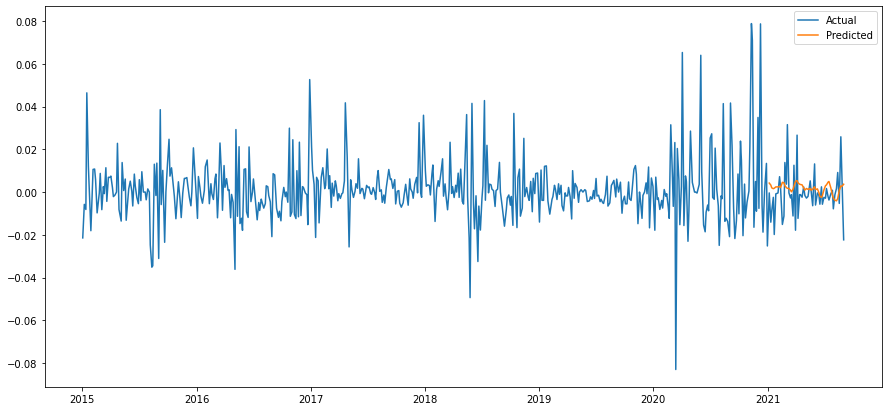

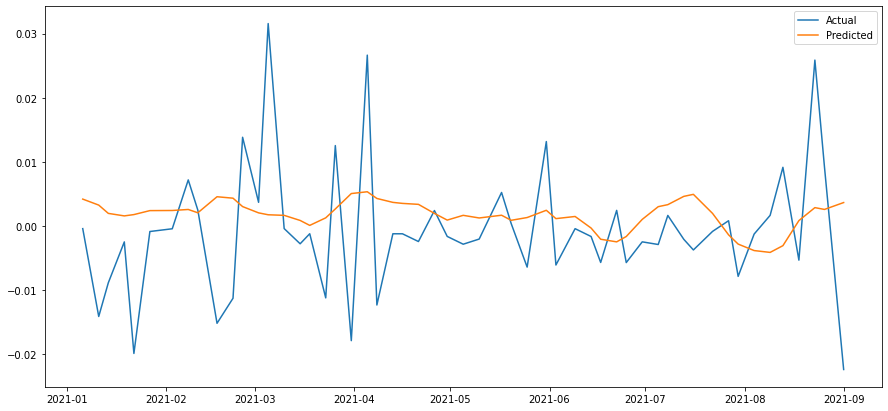

In [17]:
TEST_DATE = '2021-01-01'
END_DATE = '2021-09-01'

# Create train and test sets
df_train = df_analysis[df_analysis['ds'] < TEST_DATE]
df_test = df_analysis[df_analysis['ds'] >= TEST_DATE]

# Fit the training set
model = Prophet(weekly_seasonality=True, daily_seasonality=True)
model.fit(df_train)

# Predict
df_predict = df_test.drop(columns=['y'])
preds = model.predict(df_predict)
display(preds.info())
display(preds.head())

# Evaluate
y_true = df_test['y'].values
y_pred = preds['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
display('MAE: %.3f' % mae)

# Plot expected vs actual
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(df_analysis['ds'], df_analysis['y'], label='Actual')
plt.plot(df_predict['ds'], y_pred, label='Predicted')
plt.legend()
plt.show()

plt.plot(df_test['ds'], y_true, label='Actual')
plt.plot(df_predict['ds'], y_pred, label='Predicted')
plt.legend()
plt.show()